In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import re
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from captum.attr import IntegratedGradients

from sklearn.model_selection import KFold

# import RNA

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [18]:
# input1 = torch.load("/home/ec2-user/internship/modeling/testing/test1_ae_cnn/input1.pt")
# labels = torch.load("/home/ec2-user/internship/modeling/testing/test1_ae_cnn/input_labels.pt")
# input2 = torch.load("../latent_features.pt")


In [11]:

input1 = torch.load("../test1_ae_cnn/input1.pt")
labels = torch.load("../test1_ae_cnn/input_labels.pt")
input2 = torch.load("../latent_features.pt")
# input2 = input2.unsqueeze(1)

In [1]:
input2 = torch.stack(input2, dim=0)

NameError: name 'torch' is not defined

In [6]:
class CustomDataset(Dataset):
    def __init__(self, input1, input2, labels):
        self.input1 = input1
        self.input2 = input2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            'input1': self.input1[idx],
            'input2': self.input2[idx],
            'label': self.labels[idx]
        }
        return sample


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class TwoBranchCNNLSTMRegressor(nn.Module):
    def __init__(self, input_channels1, input_dim2, hidden_dim, layer_dim, output_size):
        super(TwoBranchCNNLSTMRegressor, self).__init__()
        
        # CNN branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(input_channels1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            ResidualBlock(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResidualBlock(128),
            nn.AdaptiveMaxPool2d((25, 1)),
            nn.Dropout(0.4)
        )
        
        # LSTM branch
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True)
        self.lstm_fc = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4)
        )
        
        total_fc_input_size = self.calculate_fc_input_size(input_channels1, hidden_dim)
        self.fc1 = nn.Linear(total_fc_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, output_size)

    def calculate_fc_input_size(self, input_channels1, hidden_dim):
        dummy_input1 = torch.zeros(1, input_channels1, 100, 4)
        dummy_output1 = self.branch1(dummy_input1)
        dummy_output1_size = dummy_output1.numel()
        return dummy_output1_size + hidden_dim

    def forward(self, x1, x2):
        x1 = self.branch1(x1)
        x1 = x1.view(x1.size(0), -1)

        x2 = x2.squeeze(1)  
        
        h0 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).to(x2.device)
        c0 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).to(x2.device)
        out, _ = self.lstm(x2, (h0, c0))
        x2 = self.lstm_fc(out[:, -1, :])

        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.output_layer(x)
        return output


In [8]:
class WeightedMSELoss(torch.nn.Module):
    def __init__(self, zero_weight, non_zero_weight):
        super(WeightedMSELoss, self).__init__()
        self.zero_weight = zero_weight
        self.non_zero_weight = non_zero_weight

    def forward(self, predictions, targets):
        non_zero_mask = (targets != 0).type(torch.float32)
        
        weights = (non_zero_mask * self.non_zero_weight) + ((1 - non_zero_mask) * self.zero_weight)
        
        loss = (weights * ((predictions - targets) ** 2)).mean()
        return loss

In [18]:
# KFold cross-validation
y = [x for x in range(len(labels))]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_edit = []
y_pred = []

for fold, (train_index, val_index) in enumerate(kf.split(y)):
    print(f"\nFold {fold + 1}")

    train_dataset1 = torch.utils.data.Subset(input1, indices=train_index)
    train_dataset2 = torch.utils.data.Subset(input2, indices=train_index)
    train_label = torch.utils.data.Subset(labels, indices=train_index)
    
    val_dataset1 = torch.utils.data.Subset(input1, indices=val_index)
    val_dataset2 = torch.utils.data.Subset(input2, indices=val_index)
    val_label = torch.utils.data.Subset(labels, indices=val_index)
    
    train_dataset = CustomDataset(input1=train_dataset1, input2=train_dataset2, labels=train_label)
    val_dataset = CustomDataset(input1=val_dataset1, input2=val_dataset2, labels=val_label)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=True)
    
    # Modify the model initialization here
    model = TwoBranchCNNLSTMRegressor(input_channels1=4, input_dim2=32, hidden_dim=128, layer_dim=2, output_size=1)
    model.to(device)
    criterion = WeightedMSELoss(0.25, 0.75)  
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 15
    
    for epoch in range(num_epochs):
        lst_edit = []
        lst_pred = []
        
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            X1 = batch['input1'].to(device)
            X2 = batch['input2'].to(device)
            y = batch['label'].to(device)
    
            optimizer.zero_grad()
            outputs = model(X1, X2)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item() * X1.size(0)
    
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                X1 = batch['input1'].to(device)
                X2 = batch['input2'].to(device)  
                y = batch['label'].to(device)
    
                outputs = model(X1, X2)
                loss = criterion(outputs, y)
    
                val_loss += loss.item() * X1.size(0)
                
                lst_edit.extend(y.tolist())
                lst_pred.extend(outputs.tolist())
                
    
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
    
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    y_edit.extend(lst_edit)
    y_pred.extend(lst_pred)
    torch.save(model, f'./p04_CNN_LSTM_model_{fold}.pt')



Fold 1


KeyboardInterrupt: 

In [10]:
from sklearn.model_selection import train_test_split


input1_train, input1_subset, input2_train, input2_subset, labels_train, labels_subset = train_test_split(
    input1, input2, labels, test_size=0.2
)

ValueError: Found input variables with inconsistent numbers of samples: [724300, 362150, 724300]

In [9]:
input_dataset = CustomDataset(input1=input1_subset, input2=input2_subset, labels=labels_subset)
input_loader = DataLoader(input_dataset, batch_size=128, shuffle=True, drop_last=True)
###
model = torch.load('./p04_CNN_LSTM_model_0.pt')
model.to(device)

NameError: name 'input1_subset' is not defined

In [21]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in input_loader:
        input1 = batch['input1'].to(device)
        input2 = batch['input2'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input1, input2)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

predicted = all_preds.flatten()
true_labels = all_labels.flatten()

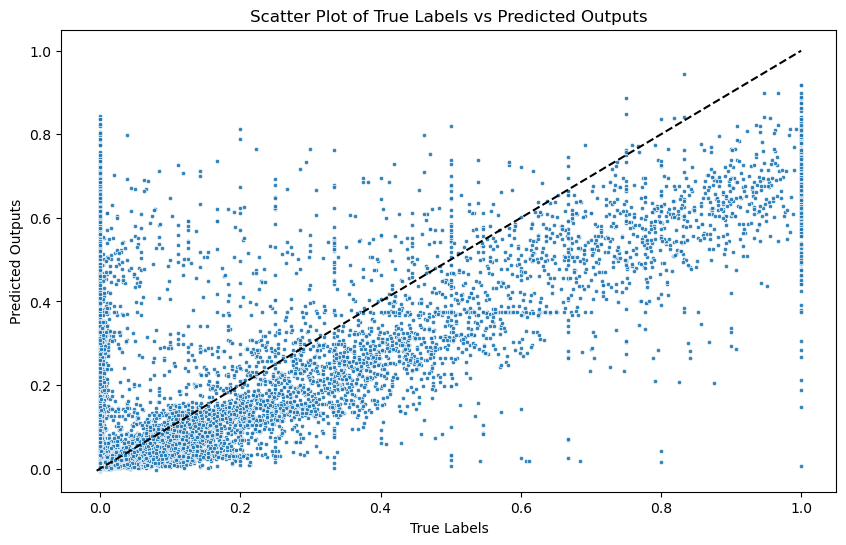

In [28]:
# Generate scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(true_labels, predicted, alpha=0.9, edgecolors='w', linewidth=0.5, s=10)
plt.xlabel('True Labels')
plt.ylabel('Predicted Outputs')
plt.title('Scatter Plot of True Labels vs Predicted Outputs')
min_val = min(true_labels.min(), predicted.min())
max_val = max(true_labels.max(), predicted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='x=y Line') 
plt.savefig("./test1_scatterplot.png")
plt.show()


In [23]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
r2 = r2_score(true_labels, predicted)

# Calculating correlation coefficient
correlation, _ = pearsonr(true_labels, predicted)
correlation1, _ = spearmanr(true_labels, predicted)

print("R^2:", r2)
print("Pearsonr coefficient:", correlation)
print("Spearmanr coefficient:", correlation1)

R^2: 0.6329097427687609
Pearsonr coefficient: 0.8013952840485499
Spearmanr coefficient: 0.3913486783965207


In [ ]:
# model.eval()

# input_loader = DataLoader(input_dataset, batch_size=256, shuffle=True, drop_last=True)

# N = 0
# for batch in input_loader:
#     X1 = batch['input1'].to(device)
#     X2 = batch['input2'].to(device)
#     y_edit = batch['label'].to(device)

#     ig = IntegratedGradients(model)
    
#     baseline = (torch.zeros_like(X1), torch.zeros_like(X2))
    
#     attributions, delta = ig.attribute((X1, X2), baseline, target=0, return_convergence_delta=True)
    
#     attributions_np1 = attributions[0].cpu().detach().numpy()
#     attributions_np2 = attributions[1].sum(dim=1).cpu().detach().numpy()
    
#     data1 = np.mean(attributions_np1, axis=0)
#     data2 = np.mean(attributions_np2, axis=0)
    
#     np.save('plot/p22_IG_input1_'+str(N)+'.npy', data1)
#     np.save('plot/p22_IG_input2_'+str(N)+'.npy', data2)
    
#     N = N + 1


In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# list_file = []
# for path, dirnames, filenames in os.walk('plot'):
#     list_file += filenames

# list_file = [i for i in list_file if 'p22_IG_input2' in i]
# lst1 = []
# lst2 = []
# for f in list_file:
#     d1 = np.load('plot/' + f.replace('input2', 'input1'))
#     d2 = np.load('plot/' + f)
#     lst1.append(d1)
#     lst2.append(d2)
#     break
# x = [i for i in range(0, 11) if i != 0]
# data1 = np.sum(lst1, axis=0)
# data2 = np.sum(lst2, axis=0)
# lst_x = [i for i in range(-31, 0)] + [i + 1 for i in range(10)]
# lst_col_color = ['#AFC4DC' for i in range(6)] + ['#FBC750' for i in range(25)] + ['#FB7072' for i in range(6)] + ['#AFC4DC' for i in range(4)]

# for N, v in enumerate(['Target', 'Spacer', 'Editing', 'C Region and PAM']):
#     data1_sub = data1[N]
#     df1_sub = pd.DataFrame(data1_sub, index=lst_x, columns=['A', 'C', 'G', 'T'])
#     df1_sub = df1_sub.loc[x]
#     plt.figure()
#     sns.clustermap(data=df1_sub, row_colors=lst_col_color, row_cluster=False, col_cluster=False,
#                    cmap='bwr', center=0, annot=True, fmt='.3f', figsize=(4, 6), linecolor='k',
#                    linewidth=0.5, dendrogram_ratio=0.05, cbar_pos=None, edgecolor='k',
#                    annot_kws={"size": 8, "color": "black"})
#     plt.title(v)
#     plt.savefig('plot/p23_clustermap_input1_'+v.replace(' ', '_')+'.png', bbox_inches='tight', dpi=300)
#     plt.savefig('plot/p23_clustermap_input1_'+v.replace(' ', '_')+'.pdf', bbox_inches='tight', dpi=300)
#     plt.show()
#     plt.close('all')
    
